In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_multivector
import math
from qiskit import qasm3
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_qsphere
from qiskit import transpile
from qiskit.visualization import plot_state_city, plot_histogram
from pylatexenc import *
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit import *
from qiskit.circuit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_multivector
import math
from qiskit import qasm3
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit import transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit_aer import AerSimulator

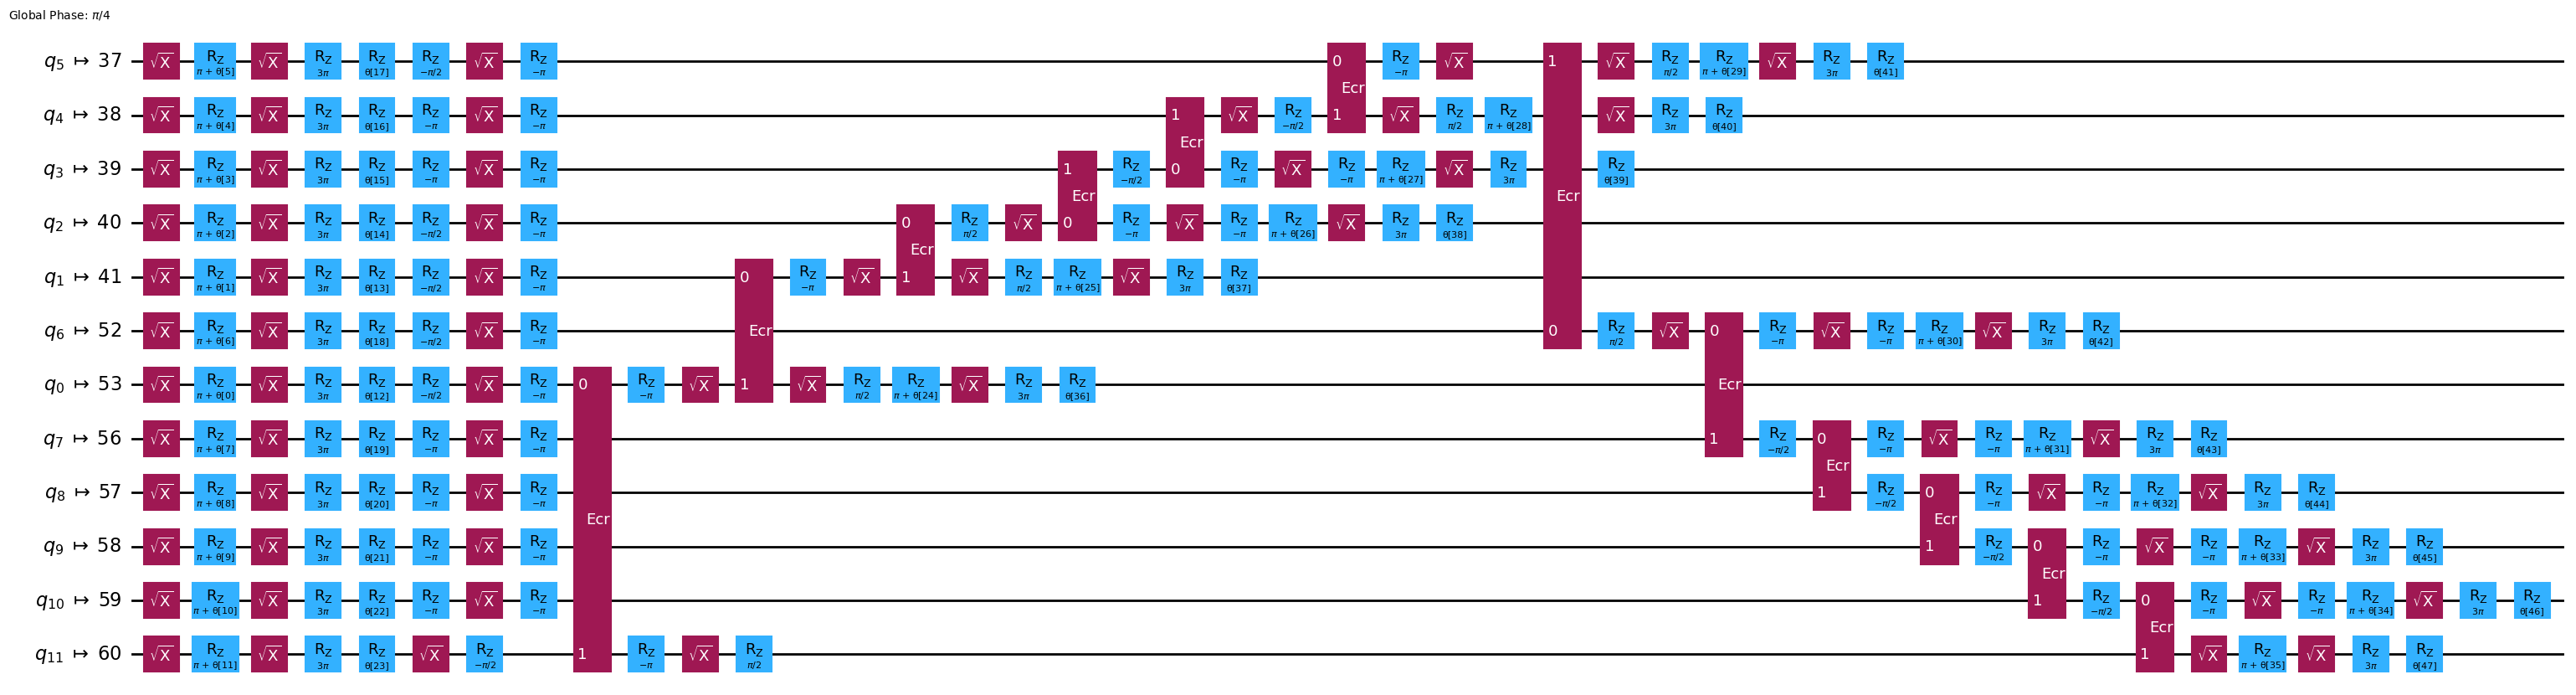

In [26]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import efficient_su2
 
qc = efficient_su2(12, entanglement="circular", reps=1)
pm = generate_preset_pass_manager(1, target=target, seed_transpiler=12345)
qc_t = pm.run(qc)
qc_t.draw("mpl", fold=-1, idle_wires=False)

In [3]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeSherbrooke

def draw(circuit):
    from qiskit import transpile
 
    scheduled = transpile(
        circuit,
        optimization_level=0,
        instruction_durations=InstructionDurations(),
        scheduling_method="alap",
    )
    return timeline_drawer(scheduled)

circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)

circ.measure_all()

backend = FakeSherbrooke()
backend.set_options(
    max_parallel_threads = 0,  # Use all CPU cores
    max_parallel_experiments = 0,  # maximum no of experiments may be executed parallel
    max_parallel_shots = 42,             # changing 1 to 42
    statevector_parallel_threshold = 16   # qubit should be greater 16 to enable parallelization of matrix multiplication
)

durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),
     ("x", None, 50), ("measure", None, 1000)]
)

# balanced X-X sequence on all qubits
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circ)
draw(circ_dd)

raw_counts = []
counts_After_DD = backend.run(circ_dd, shots =1000).result().get_counts()
print(counts_After_DD)

ImportError: cannot import name 'ALAPSchedule' from 'qiskit.transpiler.passes' (/Users/glaucoreis/anaconda3/lib/python3.11/site-packages/qiskit/transpiler/passes/__init__.py)

In [4]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy()

#DYNAMICAL DECOUPLING
estimator = Estimator(mode=backend)
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XpXm"

#Pauli twirling
estimator = Estimator(mode=backend)
estimator.options.twirling.enable_gates = True
estimator.options.twirling.num_randomizations = 32
estimator.options.twirling.shots_per_randomization = 100

#Twirled readout error extinction (TREX)
estimator = Estimator(mode=backend)
estimator.options.resilience.measure_mitigation = True
estimator.options.resilience.measure_noise_learning.num_randomizations = 32
estimator.options.resilience.measure_noise_learning.shots_per_randomization = 100

#Zero-noise extrapolation (ZNE)
estimator = Estimator(mode=backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = (1, 3, 5)
estimator.options.resilience.zne.extrapolator = "exponential"

#Probabilistic Error Amplification (PEA)
estimator = Estimator(mode=backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.amplifier = "pea"

#Probabilistic error cancellation (PEC)
estimator = Estimator(mode=backend)
estimator.options.resilience.pec_mitigation = True
estimator.options.resilience.pec.max_overhead = 100

In [9]:
from qiskit import QuantumCircuit
from qiskit.transpiler.passes import PadDynamicalDecoupling, ALAPScheduleAnalysis, BasisTranslator
from qiskit.transpiler import PassManager
from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit.providers.fake_provider import FakeMontreal

# Initialize a service and get a backend (or use a simulator)
service = QiskitRuntimeService()
#backend = service.backend("ibm_brisbane")  # Or use a simulator like FakeMontreal()
# backend = FakeMontreal() # for simulation
backend = AerSimulator()
# Get the target information from the backend
target = backend.target

# Define the DD sequence (e.g., CPMG)
dd_sequence = ['X']  # Example: CPMG sequence (single X pulse)

# Create a quantum circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Create a pass manager
pm = PassManager()

# Add passes for scheduling and basis translation
pm.append(ALAPScheduleAnalysis(target=target))
pm.append(BasisTranslator(target=target, basis_gates=target.operation_names))

# Add the PadDynamicalDecoupling pass
pm.append(PadDynamicalDecoupling(
    dd_sequence=dd_sequence,
    dd_spacing='middle',
    duration_multiplier=1,
    pulse_alignment=1, # Ensure timing is correct
    target=target
))

# Run the pass manager on the circuit
compiled_circuit = pm.run(qc)

# Print the compiled circuit
compiled_circuit.draw('mpl')

TypeError: BasisTranslator.__init__() got an unexpected keyword argument 'basis_gates'

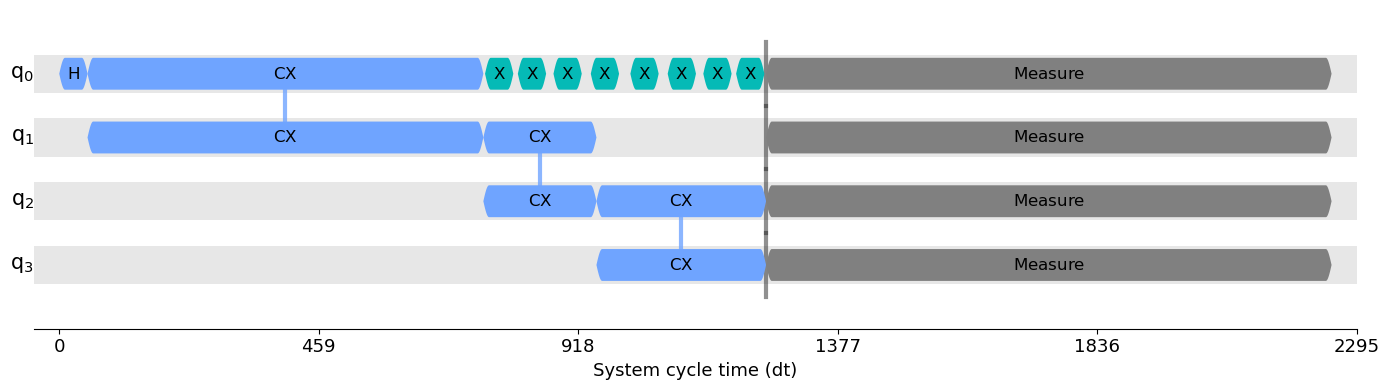

In [10]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations, Target, CouplingMap
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer
 
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()
durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),
     ("x", None, 50), ("measure", None, 1000)],
    dt=1e-7
)
target = Target.from_configuration(
    ["h", "cx", "reset", "x", "measure"],
    num_qubits=4,
    coupling_map=CouplingMap.from_line(4, bidirectional=False),
    instruction_durations=durations,
    dt=1e-7,
)
 
# balanced X-X sequence on all qubits
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence)])
circ_dd = pm.run(circ)
timeline_drawer(circ_dd, target=target)
 
# Uhrig sequence on qubit 0
n = 8
dd_sequence = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing = []
for k in range(n):
    spacing.append(uhrig_pulse_location(k) - sum(spacing))
spacing.append(1 - sum(spacing))
pm = PassManager(
    [
        ALAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence, qubits=[0], spacing=spacing),
    ]
)
circ_dd = pm.run(circ)
timeline_drawer(circ_dd, target=target)

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
 
target = backend.target
basis_gates = list(target.operation_names)
print(basis_gates)

['measure', 'ecr', 'rz', 'sx', 'delay', 'reset', 'id', 'x']


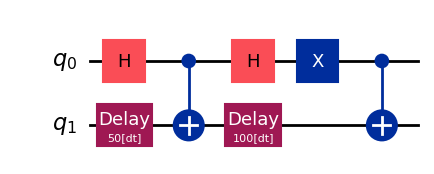

In [25]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import efficient_su2
 
#qc = efficient_su2(12, entanglement="circular", reps=1)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.x(0)
qc.cx(0, 1)
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence)])
qc_t = pm.run(qc)
qc_t.draw("mpl", fold=-1, idle_wires=False)

In [ ]:
qc = QuantumCircuit(3)
qc.x([2])
qc.h([0,1,2])
qc.barrier([0,1,2])
qft = QFT(3).decompose()
qall = QuantumCircuit(3)
qall = qall.compose(qc)
qall = qall.compose(qft)

native gates:['delay', 'ecr', 'id', 'measure', 'reset', 'rz', 'sx', 'x']


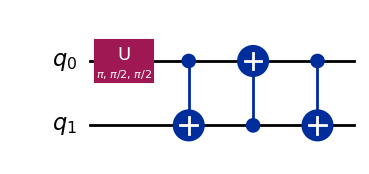

In [29]:
print("native gates:" + str(sorted(backend.operation_names)))
qc = QuantumCircuit(2)
qc.y(0)
qc.swap(0,1)
qc.decompose().draw("mpl")

In [30]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_runtime.fake_provider import FakeKyiv

creg = ClassicalRegister(1, "creg")
qreg = QuantumRegister(1, "qreg")
qc = QuantumCircuit(qreg,creg)
qc.measure_all()
backend = BasicProvider().get_backend('basic_simulator')
result = backend.run(qc, shots=256).result()
counts = result.get_counts()
print(counts)

{'0 0': 256}


In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session

# Salva uma API Key
IBMRuntimeService.save_account(auth="cloud", token="YOUR_IBM_CLOUD_API_KEY", instance="YOUR_IBM_CLOUD_CRN")

# Ou utilize um token que já tenha 
IBMRuntimeService.save_account(auth="ibm_quantum", token="YOUR_IBM_QUANTUM_API_TOKEN")

# Utilizando uma credencial salva
service = IBMRuntimeService()

# Crie seus circuitos normalmente 
qc = QuantumCircuit(2)
qc.h(0)

# efetue as medidas normalmente
backend = service.backend("ibm_brisbane")
result = backend.run(qc, shots=256).result()
counts = result.get_counts()
print(counts)

NameError: name 'IBMRuntimeService' is not defined

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
 
service = QiskitRuntimeService()
print(service.backends())


backend = service.backend("ibm_brisbane")
target = backend.target
basis_gates = list(target.operation_names)
print(basis_gates)


[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]
['measure', 'ecr', 'rz', 'sx', 'delay', 'reset', 'id', 'x']


In [40]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Salvando credenciais
QiskitRuntimeService.save_account(
    channel="ibm_cloud",  # or "ibm_cloud" for IBM Cloud accounts
    token="DEofJqdyhnwq9hKlPR0fZYZVuAcrx6d3zOAyQHkvRlgI",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ce20f97c55204afaa6ac7d0808acd5a6:6112df4b-3326-46cf-94f2-6e0328a06584::", # Uncomment and set if using ibm_cloud
    set_as_default=True,  # Set this account as the default for future sessions
    overwrite=True # Overwrite if an account is already saved
)
# Criando instância de Service
service = QiskitRuntimeService()
# Listando backends disponíveis
print("Available backends:")
for backend in service.backends():
    print(f"- {backend.name}")
# Selecionando um backend
backend = service.backend("ibm_torino") 
# Daqui em diante, como os exemplos criados até agora
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler
# Crie o circuito
qc = QuantumCircuit(2, 2)
#qc.h(0)
#qc.cx(0, 1)
qc.measure([0, 1], [0, 1])
# Execute o circuito e obteha os resultados
job = Sampler(backend).run([qc])
print(job.result())

Available backends:
- ibm_brisbane
- ibm_torino
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-08-11 17:44:03', stop='2025-08-11 17:44:07', size=4096>)])}, 'version': 2})
